In [1]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from typing import Iterable, Any, Tuple, Dict


# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, average_precision_score, balanced_accuracy_score, accuracy_score


# Custom models
import importlib
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

import preprocess_data as ppd
import GAMinferenceModels_V2 as gam_models

# Data

In [2]:
weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_dataset_compressed.csv"

all_data_df, _, feature_names, target_columns, integer_encoding = ppd.preprocess_data(failure_data_path=failure_data_file,
                                                                                        weather_data_path=weather_data_file,
                                                                                        power_load_data_path=power_load_file,
                                                                                        feature_names=['Temperature', 'Relative_humidity', 'Load', 'State'],
                                                                                        cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                                        state_one_hot=False,
                                                                                        initial_MC_state_filter='all',
                                                                                        technology_filter=['Gas Turbine/Jet Engine (Simple Cycle Operation)'],
                                                                                        test_periods=None
                                                                                        )

In [3]:
# temporal features for regional classifiers
all_data_df['month_sin'] = np.sin(2*np.pi*all_data_df['Datetime_UTC'].dt.month/12)
all_data_df['month_cos'] = np.cos(2*np.pi*all_data_df['Datetime_UTC'].dt.month/12)

# Get list of states from one-hot encoded columns
idx2state = {v: k for k, v in integer_encoding['States'].items()}
all_data_df['State'] = all_data_df['State'].apply(lambda x: idx2state[x])
states_list = all_data_df['State'].unique().tolist()
states_list.sort()

In [4]:
# states_list = ['TEXAS', 'CALIFORNIA', 'FLORIDA', 'NEW YORK', 'ILLINOIS']
# states_list = ['TEXAS']

# Regional classifiers

In [5]:
classifier_features = ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos']

In [6]:
def get_region_classifier_split(all_data_df, region, test_frac=0.2, seed=42):
    rng = np.random.default_rng(seed)

    all_data_df = all_data_df.drop_duplicates(subset=['Datetime_UTC', 'State']).copy()

    df = all_data_df.copy()
    df["is_region"] = (df["State"] == region).astype(int)

    # indices for positives and negatives
    pos_idx = df.index[df["is_region"] == 1].to_numpy()
    neg_idx = df.index[df["is_region"] == 0].to_numpy()

    n_pos_te = int(len(pos_idx) * test_frac)
    n_neg_te = int(len(neg_idx) * test_frac)
    pos_te = rng.choice(pos_idx, size=n_pos_te, replace=False)
    neg_te = rng.choice(neg_idx, size=n_neg_te, replace=False)
    

    test_idx = np.unique(np.concatenate([pos_te, neg_te]))
    train_idx = df.index.difference(test_idx)

    train_df = df.loc[train_idx].reset_index(drop=True)
    test_df  = df.loc[test_idx].reset_index(drop=True)
    train_df['Load_CDF'] = ppd.load_cdf(train_df, train_df)
    test_df['Load_CDF'] = ppd.load_cdf(train_df, test_df)
    return train_df, test_df

In [7]:
importlib.reload(gam_models)

<module 'GAMinferenceModels_V2' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/GAMinferenceModels_V2.py'>

In [8]:
cls_nll = {}
naive_nll = {}
roc_auc = {}
regional_models = {}

eps = 1e-15  # for numerical safety

for region in tqdm(states_list, desc="Regions"):
    train_state_df, test_state_df = get_region_classifier_split(all_data_df, region)

    # fit
    region_model = gam_models.regional_classifier(
        train_data=train_state_df,
        region=region,
        classifier_feats=classifier_features,
    )
    regional_models[region] = region_model

    # ----- evaluation -----
    X_te = test_state_df[classifier_features]
    y_te = test_state_df["is_region"].to_numpy()

    # model predicted probability of being in region
    p_te = region_model.predict_proba(X_te)[:, 1]
    p_te = np.clip(p_te, eps, 1 - eps)

    # naive constant probability using TRAIN prevalence (fair baseline)
    p0 = train_state_df["is_region"].mean()
    p0 = float(np.clip(p0, eps, 1 - eps))
    p_naive = np.full(y_te.shape, p0, dtype=float)

    # roc auc
    roc_auc[region] = roc_auc_score(y_te, p_te)

    cls_nll[region] = log_loss(y_te, p_te, labels=[0, 1])
    naive_nll[region] = log_loss(y_te, p_naive, labels=[0, 1])

Regions: 100%|██████████| 47/47 [02:46<00:00,  3.54s/it]


In [9]:
def plot_delta_nll_by_region(delta_nll_dict, figsize=(14, 6),
                            title="Regional classifier improvement over naive baseline",
                            ylabel="Δ NLL (Naive − Model)", fontsize=14, ticksize=12):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    df = pd.DataFrame({"region": list(delta_nll_dict.keys()),
                       "delta": list(delta_nll_dict.values())}).sort_values("delta", ascending=False)

    regions = df["region"].values
    delta = df["delta"].values
    x = np.arange(len(regions))

    fig, ax = plt.subplots(figsize=figsize)

    colors = ["#2ca02c" if d > 0 else "#d62728" for d in delta]
    bars = ax.bar(x, delta, color=colors, alpha=0.9)

    ax.axhline(0, color="black", linewidth=1.2, linestyle="--")
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize + 2)
    ax.set_xticks(x)
    ax.set_xticklabels(regions, rotation=45, ha="right", fontsize=ticksize)



    ax.grid(axis="y", alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(handles=[
        Patch(facecolor="#2ca02c", label="Better than baseline"),
        Patch(facecolor="#d62728", label="Worse than baseline"),
    ], frameon=False)

    plt.tight_layout()
    plt.show()


def plot_roc_auc_by_region(roc_auc_dict, figsize=(14, 6),
                           title="Regional classifier ROC AUC",
                           ylabel="ROC AUC", fontsize=14, ticksize=12, sort=True):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    df = pd.DataFrame({"region": list(roc_auc_dict.keys()),
                       "auc": list(roc_auc_dict.values())})

    if sort:
        df = df.sort_values("auc", ascending=False)

    regions = df["region"].values
    auc_vals = df["auc"].values
    x = np.arange(len(regions))

    fig, ax = plt.subplots(figsize=figsize)

    colors = ["#2ca02c" if a > 0.5 else "#d62728" for a in auc_vals]
    bars = ax.bar(x, auc_vals, color=colors, alpha=0.9)

    ax.axhline(0.5, color="black", linewidth=1.2, linestyle="--")
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize + 2)
    ax.set_xticks(x)
    ax.set_xticklabels(regions, rotation=45, ha="right", fontsize=ticksize)
    ax.set_ylim(0.49, 1.0)


    ax.grid(axis="y", alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(handles=[
        Patch(facecolor="#2ca02c", label="Better than random (AUC > 0.5)"),
        Patch(facecolor="#d62728", label="Worse than random (AUC ≤ 0.5)"),
    ], frameon=False)

    plt.tight_layout()
    plt.show()

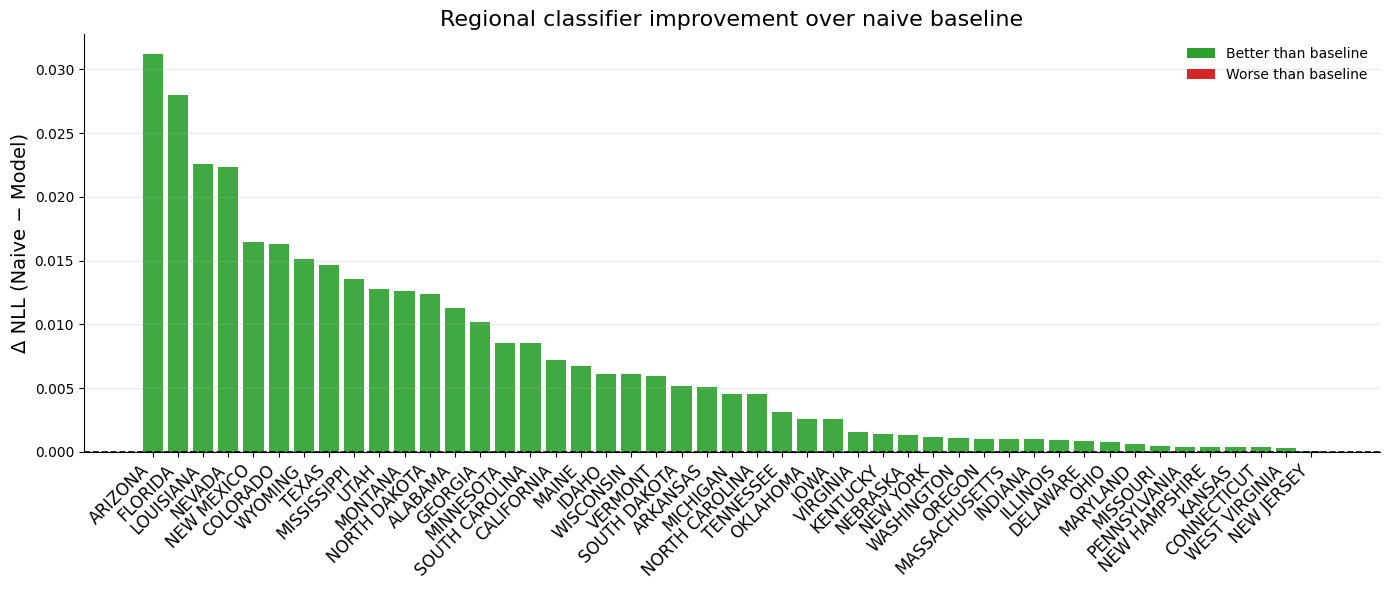

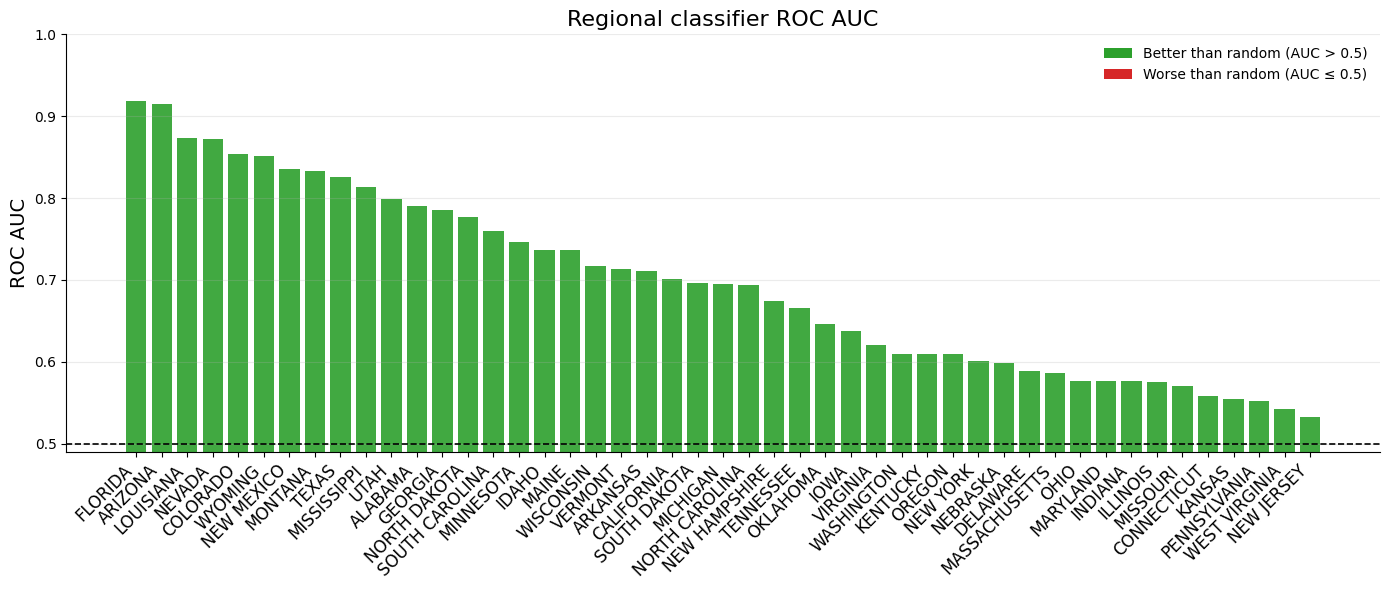

In [10]:
delta_nll = {r: naive_nll[r] - cls_nll[r] for r in cls_nll}


plot_delta_nll_by_region(delta_nll)

plot_roc_auc_by_region(roc_auc)

# Train transition models

In [11]:
importlib.reload(gam_models)

<module 'GAMinferenceModels_V2' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/GAMinferenceModels_V2.py'>

In [ ]:
feature_cols = ['Temperature', 'Load_CDF', 'psi1', 'psi2', 'psi3', 'psi4']
base_model_factory = gam_models.make_gam_factory_spline_only(
    n_features=len(feature_cols),
    n_splines=10,
)

transition_models_full, test_datasets_full, ess_res_full = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                            regions= states_list,
                                                                            feature_cols= feature_cols,
                                                                            regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                            base_model_factory= base_model_factory,
                                                                            test_frac= 0.2,
                                                                            seed= 42,
                                                                            w_region_consider= True,
                                                                            w_stress_consider= True,
                                                                            gamma= 1.0,
                                                                            clipping_quantile= 0.95,
                                                                            verbose= False)
                                                                           

Training regions:   0%|          | 0/47 [00:00<?, ?it/s]/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Use

In [ ]:
importlib.reload(gam_models)

In [ ]:
gam_models.export_gam_predictions(
    transition_models= transition_models_full,
    test_datasets= test_datasets_full,
    feature_cols= feature_cols,
    out_dir='../Results/GAM/full/',
    model_name='full'
)

In [ ]:
feature_cols = ['Temperature', 'Load_CDF', 'psi1', 'psi2', 'psi3', 'psi4']
base_model_factory = gam_models.make_gam_factory_spline_only(
    n_features=len(feature_cols),
    n_splines=10,
)

transition_models_Ar, test_datasets_Ar, ess_res_Ar = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                            regions= states_list,
                                                                            feature_cols= feature_cols,
                                                                            regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                            base_model_factory= base_model_factory,
                                                                            test_frac= 0.2,
                                                                            seed= 42,
                                                                            w_region_consider= False,
                                                                            w_stress_consider= True,
                                                                            gamma= 1.0,
                                                                            clipping_quantile= 0.95,
                                                                            verbose= False)
                                                                           

In [ ]:
importlib.reload(gam_models)

In [ ]:
gam_models.export_gam_predictions(
    transition_models= transition_models_Ar,
    test_datasets= test_datasets_Ar,
    feature_cols= feature_cols,
    out_dir='../Results/GAM/Ar/',
    model_name='Ar'
)

In [11]:
feature_cols = ['Temperature', 'Load_CDF', 'psi1', 'psi2', 'psi3', 'psi4']
base_model_factory = gam_models.make_gam_factory_spline_only(
    n_features=len(feature_cols),
    n_splines=10,
)

transition_models_As, test_datasets_As, ess_res_As = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                            regions= states_list,
                                                                            feature_cols= feature_cols,
                                                                            regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                            base_model_factory= base_model_factory,
                                                                            test_frac= 0.2,
                                                                            seed= 42,
                                                                            w_region_consider= True,
                                                                            w_stress_consider= False,
                                                                            gamma= 1.0,
                                                                            clipping_quantile= 0.95,
                                                                            verbose= False)
                                                                           

Training regions:   0%|          | 0/47 [00:00<?, ?it/s]/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Use

did not converge


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
Training regions:   9%|▊         | 4/47 [44:38<8:01:31, 671.88s/it]/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/User

In [12]:
gam_models.export_gam_predictions(
    transition_models= transition_models_As,
    test_datasets= test_datasets_As,
    feature_cols= feature_cols,
    out_dir='../Results/GAM/As/',
    model_name='As'
)

[OK] wrote ../Results/GAM/As/GAM_As_results_test_ALABAMA.csv | n=24519
[OK] wrote ../Results/GAM/As/GAM_As_results_test_ARIZONA.csv | n=36147
[OK] wrote ../Results/GAM/As/GAM_As_results_test_ARKANSAS.csv | n=21944
[OK] wrote ../Results/GAM/As/GAM_As_results_test_CALIFORNIA.csv | n=40897
[OK] wrote ../Results/GAM/As/GAM_As_results_test_COLORADO.csv | n=29400
[OK] wrote ../Results/GAM/As/GAM_As_results_test_CONNECTICUT.csv | n=23724
[OK] wrote ../Results/GAM/As/GAM_As_results_test_DELAWARE.csv | n=29551
[OK] wrote ../Results/GAM/As/GAM_As_results_test_FLORIDA.csv | n=38906
[OK] wrote ../Results/GAM/As/GAM_As_results_test_GEORGIA.csv | n=28976
[OK] wrote ../Results/GAM/As/GAM_As_results_test_IDAHO.csv | n=17706
[OK] wrote ../Results/GAM/As/GAM_As_results_test_ILLINOIS.csv | n=45395
[OK] wrote ../Results/GAM/As/GAM_As_results_test_INDIANA.csv | n=43534
[OK] wrote ../Results/GAM/As/GAM_As_results_test_IOWA.csv | n=26467
[OK] wrote ../Results/GAM/As/GAM_As_results_test_KANSAS.csv | n=25586
[